In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        raise NotImplementedError("Subclass must implement this method.")


In [2]:
class BasicVAE(VAE):
    def __init__(self):
        super(BasicVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
class EncoderDecoderEncoderVAE(VAE):
    def __init__(self):
        super(EncoderDecoderEncoderVAE, self).__init__()
        # Encoder-Encoder
        self.encoder_fc1 = nn.Linear(784, 400)
        self.encoder_fc2 = nn.Linear(400, 200)
        self.decoder_fc1 = nn.Linear(200, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.encoder_fc1(x))
        h2 = F.relu(self.encoder_fc2(h1))
        h3 = F.relu(self.decoder_fc1(h2))
        return self.fc21(h3), self.fc22(h3)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [10]:
class EncoderDecoderDecoderVAE(VAE):
    def __init__(self):
        super(EncoderDecoderDecoderVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        # Decoder-Encoder
        self.decoder_fc1 = nn.Linear(20, 100)
        self.decoder_fc2 = nn.Linear(100, 200)
        self.encoder_fc1 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 20)
        self.fc4 = nn.Linear(20, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h1 = F.relu(self.decoder_fc1(z))
        h2 = F.relu(self.decoder_fc2(h1))
        h3 = F.relu(self.encoder_fc1(h2))
        h4 = F.relu(self.fc3(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [27]:
class DualEncoderDecoderVAE(VAE):
    def __init__(self):
        super(DualEncoderDecoderVAE, self).__init__()
        # Encoder-Encoder
        self.enc1_fc1 = nn.Linear(784, 400)    # Input 784 to Output 400
        self.enc1_fc2 = nn.Linear(400, 200)    # Input 400 to Output 200
        self.enc1_dec_fc1 = nn.Linear(200, 400) # Input 200 back to Output 400 (simulating decoder within encoder)
        self.enc1_mu = nn.Linear(400, 20)      # Input 400 to Output 20 (mu)
        self.enc1_logvar = nn.Linear(400, 20)  # Input 400 to Output 20 (log-variance)

        # Decoder-Encoder
        self.dec1_fc1 = nn.Linear(20, 100)     # Input 20 (latent space) to Output 100
        self.dec1_fc2 = nn.Linear(100, 200)    # Input 100 to Output 200
        self.dec1_enc_fc1 = nn.Linear(200, 100) # Input 200 back to Output 100 (simulating encoder within decoder)
        self.dec1_output = nn.Linear(100, 784) # Final output layer: Input 100 to Output 784 (reconstructed image)

    def encode(self, x):
        h1 = F.relu(self.enc1_fc1(x))
        h2 = F.relu(self.enc1_fc2(h1))
        h3 = F.relu(self.enc1_dec_fc1(h2))
        mu = self.enc1_mu(h3)
        logvar = self.enc1_logvar(h3)
        return mu, logvar

    def decode(self, z):
        h1 = F.relu(self.dec1_fc1(z))
        h2 = F.relu(self.dec1_fc2(h1))
        h3 = F.relu(self.dec1_enc_fc1(h2))
        reconstruction = torch.sigmoid(self.dec1_output(h3))
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar


In [14]:
from torchvision import datasets, transforms

# Change transform to normalize the data to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    # No normalization required if data needs to be between [0, 1]
])

# Redefine the data loaders with the new transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [17]:
import time

def train(model, train_loader, optimizer, num_epochs=10):
    model.train()
    total_start_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()
        for data, _ in train_loader:
            data = data.view(data.size(0), -1)
            data = (data + 1) / 2  # Adjusting the data if needed
            optimizer.zero_grad()
            reconstruction, mu, logvar = model(data)

            recon_loss = F.binary_cross_entropy(reconstruction, data, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_divergence

            loss.backward()
            optimizer.step()

        epoch_duration = time.time() - start_time
        print(f'Epoch {epoch+1} finished in {epoch_duration:.2f} seconds with Loss: {loss.item()}')

    total_duration = time.time() - total_start_time
    print(f'Total training time: {total_duration:.2f} seconds')


In [18]:
# Initialize the models
basic_vae = BasicVAE()
encoder_decoder_encoder_vae = EncoderDecoderEncoderVAE()
encoder_decoder_decoder_vae = EncoderDecoderDecoderVAE()
dual_encoder_decoder_vae = DualEncoderDecoderVAE()

# Initialize optimizers
optimizer_basic = Adam(basic_vae.parameters(), lr=0.001)
optimizer_ede = Adam(encoder_decoder_encoder_vae.parameters(), lr=0.001)
optimizer_edd = Adam(encoder_decoder_decoder_vae.parameters(), lr=0.001)
optimizer_ded = Adam(dual_encoder_decoder_vae.parameters(), lr=0.001)

# Train models
train(basic_vae, train_loader, optimizer_basic)
train(encoder_decoder_encoder_vae, train_loader, optimizer_ede)
train(encoder_decoder_decoder_vae, train_loader, optimizer_edd)



Epoch 1 finished in 24.37 seconds with Loss: 16785.3828125
Epoch 2 finished in 26.83 seconds with Loss: 16598.15625
Epoch 3 finished in 26.71 seconds with Loss: 16664.349609375
Epoch 4 finished in 27.18 seconds with Loss: 16540.8515625
Epoch 5 finished in 28.97 seconds with Loss: 16525.443359375
Epoch 6 finished in 29.18 seconds with Loss: 16604.9765625
Epoch 7 finished in 30.19 seconds with Loss: 16505.28515625
Epoch 8 finished in 30.12 seconds with Loss: 16471.94921875
Epoch 9 finished in 30.89 seconds with Loss: 16567.498046875
Epoch 10 finished in 30.74 seconds with Loss: 16619.173828125
Total training time: 285.19 seconds
Epoch 1 finished in 31.31 seconds with Loss: 16730.9921875
Epoch 2 finished in 34.55 seconds with Loss: 16534.12890625
Epoch 3 finished in 34.83 seconds with Loss: 16578.939453125
Epoch 4 finished in 35.00 seconds with Loss: 16505.7734375
Epoch 5 finished in 35.53 seconds with Loss: 16510.525390625
Epoch 6 finished in 36.89 seconds with Loss: 16626.470703125
Epoc

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x100 and 20x784)

In [28]:
train(dual_encoder_decoder_vae, train_loader, optimizer_ded)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x100 and 20x784)

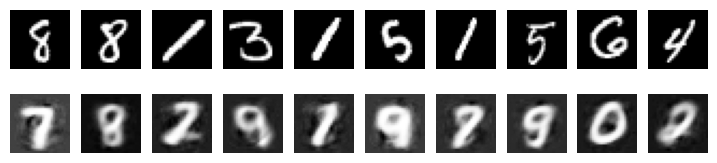

In [24]:
import matplotlib.pyplot as plt

def visualize(model, test_loader):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.view(data.size(0), -1)
        reconstruction, _, _ = model(data)
        reconstruction = reconstruction.view(-1, 28, 28)

        # Plotting
        plt.figure(figsize=(9, 2))
        for i in range(10):
            plt.subplot(2, 10, i + 1)
            plt.imshow(data[i].reshape(28, 28), cmap='gray')
            plt.axis('off')

            plt.subplot(2, 10, i + 11)
            plt.imshow(reconstruction[i].numpy(), cmap='gray')
            plt.axis('off')
        plt.show()

# Use the function to visualize outputs from any model
visualize(basic_vae, test_loader)


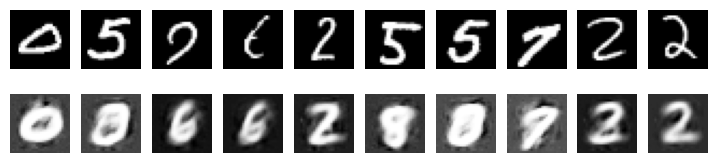

In [25]:
visualize(encoder_decoder_encoder_vae, test_loader)

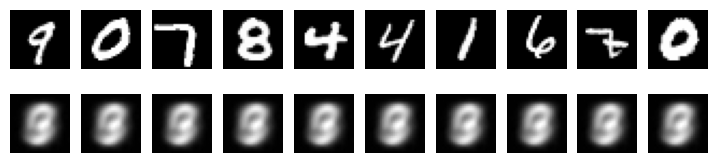

In [26]:
visualize(encoder_decoder_decoder_vae, test_loader)